In [15]:
import numpy as np
from splinv import detect
from splinv import hmod
from splinv import darkmapper
from splinv.grid import Cartesian
from configparser import ConfigParser
import splinv
import time

""" Test sparse reconstruction of weak lensing dark map
"""
# configuration
configName  =   'test_mock_catalog_atom_more_z_bins.ini'
parser      =   ConfigParser()
parser.read(configName)

# halo simulation
z_h1     =  0.13
z_h2     =  0.25
log_m1   =  14.745
M_200   =  10.**(log_m1)
conc    =  4.
halo1    =  hmod.nfwTJ03(mass=M_200,conc=conc,redshift=z_h1,ra=-935.,dec=1100.)
halo2    =  hmod.nfwTJ03(mass=M_200,conc=conc,redshift=z_h2,ra=800,dec=-1200)

generating mock catalog this way has the freedom of moving the halo around. 

In [1]:
# Reconstruction Init
parser.set('sparse','mu','3e-4')            #step size for gradient descent
parser.set('lens','resolve_lim','0.02')     #pix
parser.set('lens','rs_base','%s' %halo1.rs)  #Mpc/h
parser.set('sparse','nframe','1' )

# Pixelation
Grid    =   Cartesian(parser)
lensKer1=   Grid.lensing_kernel(deltaIn=False)


general_grid    =   hmod.triaxialJS02_grid_mock(parser)
kappa1   =   general_grid.add_halo(halo1)[0]
kappa2   =   general_grid.add_halo(halo2)[0]
shear1   =   general_grid.add_halo(halo1)[1]
shear2   =   general_grid.add_halo(halo2)[1]
gErr    =   np.ones(Grid.shape)*0.05

totalshear = shear1 + shear2

NameError: name 'parser' is not defined

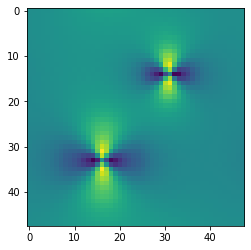

In [17]:
import matplotlib.pyplot as plt
plt.imshow(totalshear[4].real)

In [18]:
s = time.time()
dmapper =   darkmapper(parser,totalshear.real, totalshear.imag, gErr,lensKer1)

dmapper.lbd=8.      # Lasso penalty
dmapper.lcd=0.      # Ridge penalty in Elastic net
dmapper.nonNeg=True # using non-negative Lasso
dmapper.clean_outcomes()
dmapper.fista_gradient_descent_fast(3000) # run 3000 steps
#w   =   dmapper.adaptive_lasso_weight(gamma=2.) # determine the apaptive weight
#dmapper.fista_gradient_descent(3000,w=w)   
e = time.time()# run adaptive lasso
print(e-s)

35.311777114868164


In [19]:
s = time.time()
dmapper.mu=3e-3     # step size for gradient descent
for _ in range(8):  # redo apaptive lasso, letting it run for more iteration
    w   =   dmapper.adaptive_lasso_weight(gamma=2.)
    dmapper.fista_gradient_descent_fast(3000,w=w)
dmapper.reconstruct()
e = time.time()
print(e-s)

270.41483068466187


In [20]:
Grid.zlcgrid

array([0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.25,
       0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43])

In [22]:
c1  =   detect.local_maxima_3D(dmapper.deltaR)
print(c1)
logm_est1=   np.log10((dmapper.alphaR*dmapper._w)[4,0,33,16])+14.
logm_est2=   np.log10((dmapper.alphaR*dmapper._w)[10,0,14,31])+14.

(array([[ 4, 33, 16],
       [10, 14, 31]]), array([73.03130164, 40.15732271]))


In [23]:
print("First z interval:", Grid.zlcgrid[4],Grid.zlcgrid[4+1])
print("second z interval:", Grid.zlcgrid[10],Grid.zlcgrid[10+1])

First z interval: 0.13 0.14999999999999997
second z interval: 0.24999999999999994 0.26999999999999996


it worked i guess

In [24]:
print("mass 1:", logm_est1)
print("mass 2:", logm_est2)
print("true mass:", log_m1)
#when c=4, the result only agrees to unit digit

mass 1: 14.74075258201004
mass 2: 14.752890702712662
true mass: 14.745


In [25]:
print(dmapper.deltaR.shape)

(20, 48, 48)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dmapper.deltaR[4])

In [ ]:
print(dmapper.alphaR.shape)
plt.imshow(dmapper.alphaR[4,0])

In [ ]:
print(np.max(dmapper.diff))